In [1]:
import os
import tensorflow as tf
import random
import numpy as np
import matplotlib.pyplot as plt
import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
x_train = mnist.train.images[:55000, :]
x_train.shape

(55000, 784)

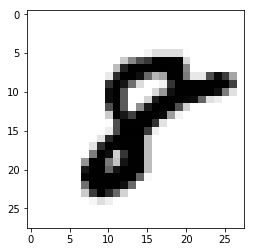

In [3]:
randomNum = random.randint(0, 55000)
image = x_train[randomNum].reshape([28,28])
plt.imshow(image, cmap=plt.get_cmap('gray_r'))
plt.show()

In [4]:
y_dim = 10
channel = 1
batch_size = 16
z_dimensions = 100
EPOCH = 5

In [5]:
# LeakyReLU
def lrelu(x, alpha=0.2):
    return tf.maximum(x, alpha*x)

def conv2d(x, W, b):
    out = tf.nn.conv2d(x, W, strides=[1, 2, 2, 1], padding='SAME')
    return tf.nn.bias_add(out, b)

def de_conv(x, W, b, out_shape):
    with tf.name_scope('deconv') as scope:
        deconv = tf.nn.conv2d_transpose(x, W, out_shape, [1, 2, 2, 1], 
                                        padding='SAME', name=None)
        out = tf.nn.bias_add(deconv, b)
        return out
    
def fully_connect(x, W, b):
    return tf.add(tf.matmul(x, W), b)

# Concatenate x and y
def conv_cond_concat(x, y):
    x_shapes = x.get_shape()
    y_shapes = y.get_shape()
    print(x_shapes)
    print(y_shapes)
    return tf.concat([x, y * tf.ones([x_shapes[0], x_shapes[1], 
                                      x_shapes[2], y_shapes[3]])], 3)

In [6]:
def discriminator(x_image, y, reuse=False):
    with tf.variable_scope('discriminator') as scope:
        if(reuse):
            tf.get_variable_scope().reuse_variables()
        
        yb = tf.reshape(y, shape=[batch_size, 1, 1, y_dim])
        input_array = conv_cond_concat(x_image, yb)
        
        # First conv layers
        W_conv1 = tf.Variable(tf.random_normal([5, 5, 11, 10], stddev=0.02), 
                              name='d_wconv1')
        b_conv1 = tf.Variable(tf.zeros([10]), 
                              name='d_bconv1' )
        h_conv1 = conv2d(input_array, W_conv1, b_conv1)
        h_conv1 = lrelu(h_conv1)
        h_conv1 = conv_cond_concat(h_conv1, yb)        
        
        # Second conv layers
        W_conv2 = tf.Variable(tf.random_normal([5, 5, 20, 64], stddev=0.02), 
                              name='d_wconv2')
        b_conv2 = tf.Variable(tf.zeros([64]), 
                              name='d_bconv2' )
        h_conv2 = conv2d(h_conv1, W_conv2, b_conv2)
        h_conv2 = tf.contrib.layers.batch_norm(h_conv2, center = True, 
                                               scale = True, is_training = True, scope = 'd_bn1')
        h_conv2 = lrelu(h_conv2)
        h_conv2 = tf.reshape(h_conv2, [batch_size, -1])
        h_conv2 = tf.concat([h_conv2, y], 1)
        
    
        # First fully connected layer
        W_fc1 = tf.Variable(tf.random_normal([7 * 7 * 64 + y_dim, 1024], stddev=0.02),
                            name='d_wfc1')
        b_fc1 = tf.Variable(tf.zeros([1024]), name='d_bfc1')
        h_fc1 = fully_connect(h_conv2, W_fc1, b_fc1)
        h_fc1 = tf.contrib.layers.batch_norm(h_fc1, center = True, 
                                               scale = True, is_training = True, scope = 'd_bn2')
        h_fc1 = lrelu(h_fc1)
        h_fc1 = tf.concat([h_fc1, y], 1)
        
        # Final layer
        W_fc2 = tf.Variable(tf.random_normal([1024 + y_dim, channel], stddev=0.02), 
                            name='d_wfc2')
        b_fc2 = tf.Variable(tf.zeros([channel]), 
                            name='d_bfc2')
        H_fc2 = fully_connect(h_fc1, W_fc2, b_fc2)
        H_fc2 = tf.nn.sigmoid(H_fc2)
        
    return H_fc2

In [7]:
def generator(batch_size, z, z_dimensions, y, reuse=False):
    with tf.variable_scope('generator') as scope:
        if (reuse):
            tf.get_variable_scope().reuse_variables()
        
        yb = tf.reshape(y, shape=[batch_size, 1, 1, y_dim])
        z = tf.concat([z, y], 1)
        output_size = 28
        c1, c2 = int(output_size/4), int(output_size/2)
    
        
        # First fully connected layer
        W_fc1 = tf.Variable(tf.random_normal([z_dimensions + y_dim, 1024], stddev=0.02), 
                            name='g_wfc1')
        b_fc1 = tf.Variable(tf.zeros([1024]), 
                            name='g_wfc1')
        H_fc1 = fully_connect(z, W_fc1, b_fc1)
        H_fc1 = tf.contrib.layers.batch_norm(H_fc1, center = True, 
                                               scale = True, is_training = True, scope = 'g_bn1')
        H_fc1 = tf.nn.relu(H_fc1)
        H_fc1 = tf.concat([H_fc1, y], 1)
        
        
        # Second fully connected layer
        W_fc2 = tf.Variable(tf.random_normal([1024 + y_dim, 7 * 7 * 2 * 64], stddev=0.02), 
                            name='g_wfc2')
        b_fc2 = tf.Variable(tf.zeros([7 * 7 * 2 * 64]), 
                            name='g_wfc2')
        H_fc2 = fully_connect(H_fc1, W_fc2, b_fc2)
        H_fc2 = tf.contrib.layers.batch_norm(H_fc2, center = True, 
                                               scale = True, is_training = True, scope = 'g_bn2')
        H_fc2 = tf.nn.relu(H_fc2)
        H_fc2 = tf.reshape(H_fc2, [batch_size, c1, c1, 64 * 2])
        H_fc2 = conv_cond_concat(H_fc2, yb)
        
        # First Deconv layer
        W_conv1 = tf.Variable(tf.random_normal([5, 5, 128, 138], stddev=0.02), 
                              name='g_wconv1')
        b_conv1 = tf.Variable(tf.zeros([128]), 
                              name='g_bconv1')
        H_conv1 = de_conv(H_fc2, W_conv1, b_conv1, out_shape=[batch_size, c2, c2, 128])
        H_conv1 = tf.contrib.layers.batch_norm(H_conv1, center = True, 
                                               scale = True, is_training = True, scope = 'g_bn3')
        H_conv1 = tf.nn.relu(H_conv1)
        H_conv1 = conv_cond_concat(H_conv1, yb)
        
        # Second Deconv layer
        W_conv2 = tf.Variable(tf.random_normal([5, 5, channel, 138], stddev=0.02), 
                              name='g_wconv2')
        b_conv2 = tf.Variable(tf.zeros([channel]), 
                              name='g_bconv2')
        H_conv2 = de_conv(H_conv1, W_conv2, b_conv2, out_shape=[batch_size, output_size, output_size, 1])
        H_conv2 = tf.nn.sigmoid(H_conv2)
    
    return H_conv2

In [8]:
sess = tf.Session()
images = tf.placeholder(tf.float32, [batch_size, 28, 28, 1])
y_placeholder = tf.placeholder(tf.float32, [None, y_dim])
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions])

In [9]:
Dx = discriminator(images, y_placeholder)
Gz = generator(batch_size, z_placeholder, z_dimensions, y_placeholder)
Dg = discriminator(Gz, y_placeholder, reuse = True)

(16, 28, 28, 1)
(16, 1, 1, 10)
(16, 14, 14, 10)
(16, 1, 1, 10)
(16, 7, 7, 128)
(16, 1, 1, 10)
(16, 14, 14, 128)
(16, 1, 1, 10)
(16, 28, 28, 1)
(16, 1, 1, 10)
(16, 14, 14, 10)
(16, 1, 1, 10)


In [10]:
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.ones_like(Dg)))
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dx, labels=tf.ones_like(Dx)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.zeros_like(Dg)))
d_loss = d_loss_real + d_loss_fake

In [11]:
tvars = tf.trainable_variables()
d_vars = [var for var in tvars if 'd_' in var.name]
g_vars = [var for var in tvars if 'g_' in var.name]

In [12]:
with tf.variable_scope(tf.get_variable_scope(), reuse=False):
    trainerD = tf.train.AdamOptimizer(learning_rate=.0002, beta1=0.5).minimize(d_loss, var_list=d_vars)
    trainerG = tf.train.AdamOptimizer(learning_rate=.0002, beta1=0.5).minimize(g_loss, var_list=g_vars)

In [13]:
sess.run(tf.global_variables_initializer())
iterations = 3000
for i in range(iterations):
    avg_dcost = 0
    avg_gcost = 0
    z_batch = np.random.normal(-1, 1, size=[batch_size, z_dimensions])
    real_image_batch = mnist.train.next_batch(batch_size)
    input_image_batch = np.reshape(real_image_batch[0], 
                                   [batch_size, 28, 28, 1])
    input_label_batch = np.reshape(real_image_batch[1],
                                   [batch_size, y_dim])
    
    _, dLoss = sess.run([trainerD, d_loss], feed_dict={images: input_image_batch,
                                                        y_placeholder: input_label_batch,
                                                        z_placeholder: z_batch})
    avg_dcost += dLoss / batch_size
    if (i % 100 == 0):
        print("Iteration:", '%04d' % (i), "dcost=", "{:.9f}".format(avg_dcost))
    
    _, gLoss = sess.run([trainerG, g_loss], feed_dict={y_placeholder: input_label_batch,
                                                       z_placeholder: z_batch})
    
    avg_gcost += gLoss / batch_size
    if (i % 100 == 0):
        print("Iteration:", '%04d' % (i), "gcost=", "{:.9f}".format(avg_gcost))

Iteration: 0000 dcost= 0.093469054
Iteration: 0000 gcost= 0.031238418
Iteration: 0100 dcost= 0.068552777
Iteration: 0100 gcost= 0.040110439
Iteration: 0200 dcost= 0.067901477
Iteration: 0200 gcost= 0.040312417
Iteration: 0300 dcost= 0.070246994
Iteration: 0300 gcost= 0.038859352
Iteration: 0400 dcost= 0.065422475
Iteration: 0400 gcost= 0.041787632
Iteration: 0500 dcost= 0.067778975
Iteration: 0500 gcost= 0.040344141
Iteration: 0600 dcost= 0.067774743
Iteration: 0600 gcost= 0.040345099
Iteration: 0700 dcost= 0.067765184
Iteration: 0700 gcost= 0.040348005
Iteration: 0800 dcost= 0.065352693
Iteration: 0800 gcost= 0.041822147
Iteration: 0900 dcost= 0.070187405
Iteration: 0900 gcost= 0.038867380
Iteration: 1000 dcost= 0.062989578
Iteration: 1000 gcost= 0.043265358
Iteration: 1100 dcost= 0.062926285
Iteration: 1100 gcost= 0.043303750
Iteration: 1200 dcost= 0.062933505
Iteration: 1200 gcost= 0.043299623
Iteration: 1300 dcost= 0.062929258
Iteration: 1300 gcost= 0.043300487
Iteration: 1400 dcos

(1, 7, 7, 128)
(1, 1, 1, 10)
(1, 14, 14, 128)
(1, 1, 1, 10)


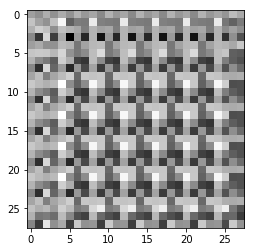

In [14]:
test_label = mnist.train.labels
randomNum = random.randint(0, 55000)
test_y = test_label[randomNum].reshape([1,10])

sample_image = generator(1, z_placeholder, z_dimensions, y_placeholder, reuse=True)
test_z = np.random.normal(-1, 1, [1, z_dimensions])

sess.run(tf.global_variables_initializer())
temp = (sess.run(sample_image, feed_dict={y_placeholder: test_y,
                                          z_placeholder: test_z}))

my_i = temp.squeeze()
plt.imshow(my_i, cmap='gray_r')
plt.show()